In [3]:
from MNIST_dataloader import create_dataloaders
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

## Exercise 1

In [6]:
torch.random.manual_seed(0)
data_loc = os.path.join(os.path.abspath("."),"MNIST")
batch_size = 64
train_loader, test_loader = create_dataloaders(data_loc,batch_size)
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels
x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels
# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

In [142]:
import torchvision.transforms.functional as TF
from PIL import Image
# TF.to_pil_image(x_clean_example[1,:,:,:]).show()
print(torch.max(x_clean_example[:,:,:,:]).item())
print(torch.min(x_clean_example[:,:,:,:]).item())

1.0
-1.0


In [158]:
def softthreshold(x,shrinkage):

    return torch.multiply(torch.sign(x),torch.max(torch.abs(x)-shrinkage,torch.zeros_like(x)))

def ISTA(mu,lambd,k,y:torch.tensor)->torch.tensor:
    """
    INPUT:
    mu:     step size                (float32)
    lambd:  shrinkage parmater       (float32)
    k:      number of iteration      (int)
    y:      measurements             (tensor)
    -----------------------------------------------
    OUTPUT:
    reconstruction: recons           (tensor)
    """
    y_shape = y.shape
    y = y.flatten() + 1
    A = torch.eye(y.shape[0])
    x_1 = torch.zeros_like(y)
    for i in range(k):
        g_1 = A.T@(y-A@x_1)
        x_2 = x_1 + mu * g_1
        x_hat = softthreshold(x_2,lambd*mu)
        # x_hat = torch.tanh(x_hat)
        error = torch.nn.functional.mse_loss(x_hat,x_1)
        if error < 1e-8:
            break
        else:
            x_1 = x_hat
    recons = x_hat.reshape((y_shape[0],y_shape[1],y_shape[2])) - 1
    return recons, x_hat, error,i

mu = 0.5
lambd = 0.9

k = 1000


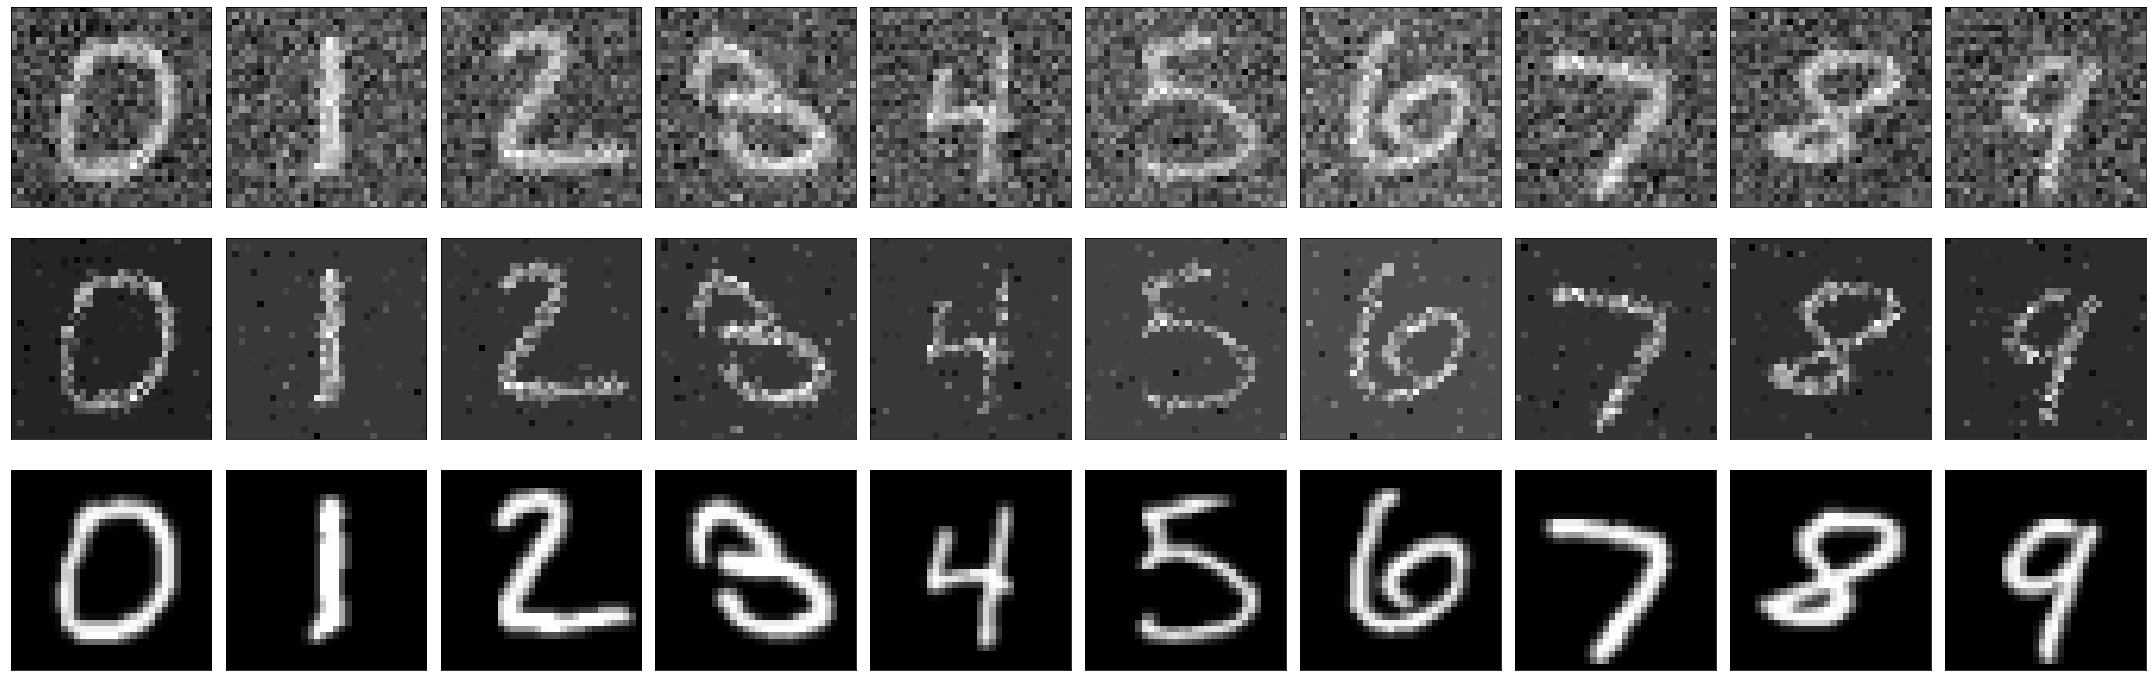

In [159]:
reconses = torch.zeros((10,1,x_noisy_example.shape[-1],x_noisy_example.shape[-1]))

plt.figure(figsize=(30,10))
for ii in range(10):
    reconses[ii,:,:,:],x_hat,error,i = ISTA(mu,lambd,k,x_noisy_example[ii,:,:,:])
    plt.subplot(3,10,ii+1)
    plt.imshow(x_noisy_example[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,ii+11)
    plt.imshow(reconses[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,ii+21)
    plt.imshow(x_clean_example[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath('.'),"figure")
if os.path.exists(fig_path):
    pass
else:
    os.makedirs(fig_path)
plt.savefig(os.path.join(fig_path,"w1e1.png"),dpi=80,bbox_inches='tight')
plt.show()

## Exercise 2